In [ ]:
# scipy peakutils kneed sklearn matplotlib tabulate shapely geopandas rioxarray earthpy

In [ ]:
import sys 
!{sys.executable} -m pip install --user geopandas

## Análisis exploratorio Satélites

In [1]:
# import necessary packages
import pandas as pd, numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import sys

filename = "jan_train.csv" #jan_test.csv#
# leo los datos y borro el id de la medición
data = pd.read_csv(filename).drop('id', axis=1)

# convierto a datetime la columna epoch (fecha y hora en que se midió la posición del satélite)
data['epoch'] = pd.to_datetime(data['epoch'], infer_datetime_format=True)

# ordeno las mediciones por sat_id (id del satélite) y epoch (fecha y hora de medición)
data.sort_values(by=['sat_id','epoch'], ascending=True, inplace=True)

# calculo las diferencias en minutos entre mediciones consecutivas de un mismo satélite
t = 30
data['diff_epoch'] = (data.groupby('sat_id')['epoch'].diff() / np.timedelta64(t, 'm')).fillna(0)

# extraigo la fecha del epoch
data['date'] = data.epoch.dt.strftime('%Y-%m-%d')
                                         
# descarto satélites con mediciones que superan los 30 minutos
to_delete = data.sat_id.isin(data[data.diff_epoch>1].sat_id.unique())
df = data[~to_delete]

In [2]:
#d1 = min(data.epoch).strftime('%Y-%m-%d')
#d2 = max(data.epoch).strftime('%Y-%m-%d')
d1, d2 = (min(data.date), max(data.date))
print(f'Rango de fechas: [ {d1} - {d2} ]')

Rango de fechas: [ 2014-01-01 - 2014-01-24 ]


In [3]:
# imprimo cantidades
print('Cantidad de filas y columnas:', data.shape, len(data)/data.sat_id.nunique())
print('Cantidad de satélites:', df.sat_id.nunique(), '/', data.sat_id.nunique())

# muestro don registros de ejemplo
df.head(2)

Cantidad de filas y columnas: (503227, 16) 838.7116666666667
Cantidad de satélites: 137 / 600


epoch  sat_id             x            y            z  \
741 2014-01-01 00:00:00.000       1  10390.313089 -2796.458271  3179.562085   
742 2014-01-01 00:21:11.845       1  11195.606833  5078.653968  -839.076593   

           Vx        Vy        Vz         x_sim        y_sim        z_sim  \
741  2.520477  6.149930 -2.827599  10405.813755 -2771.180760  3166.926302   
742 -1.126667  5.826412 -3.255872  11199.853336  5102.405255  -845.930363   

       Vx_sim    Vy_sim    Vz_sim  diff_epoch        date  
741  2.508879  6.152996 -2.826227    0.000000  2014-01-01  
742 -1.130992  5.822303 -3.250049    0.706581  2014-01-01

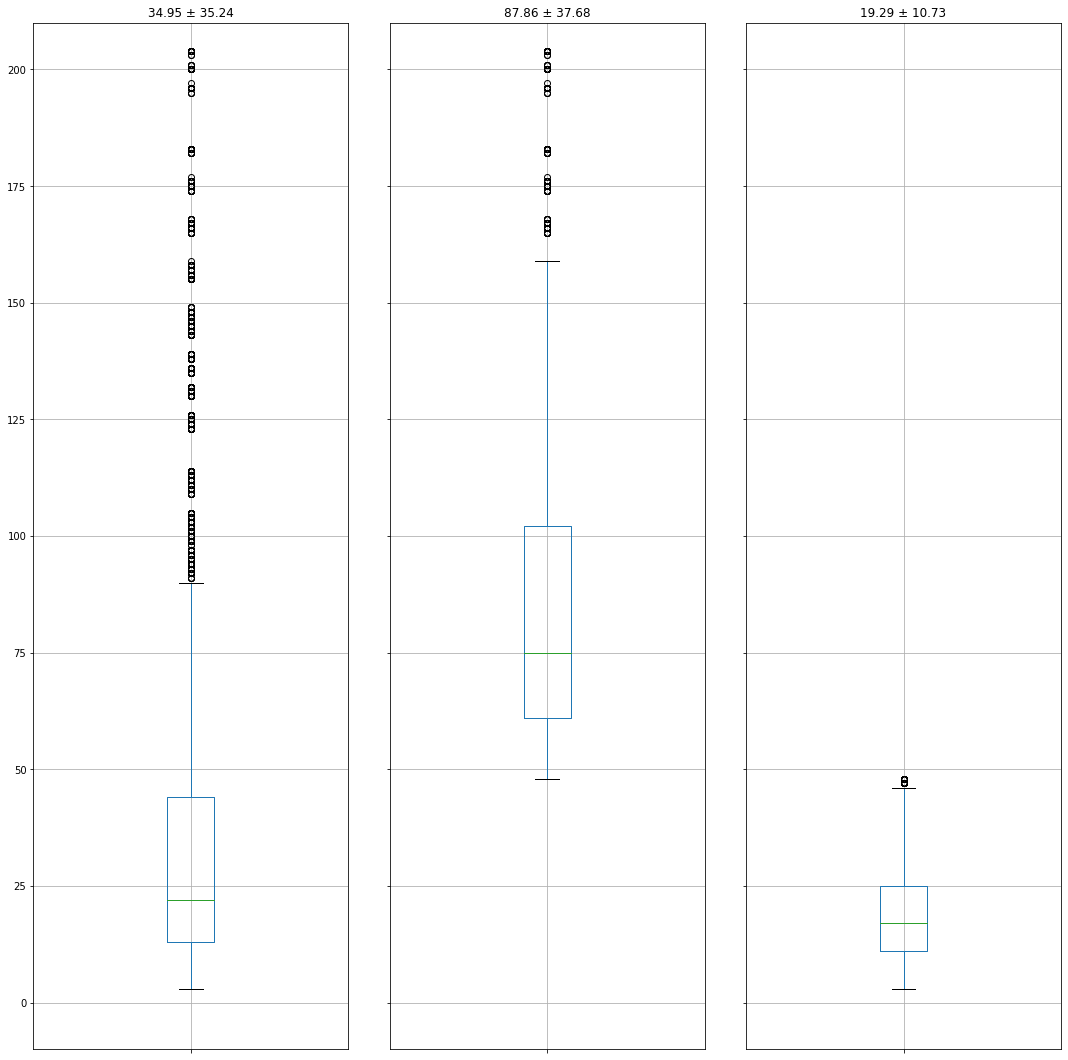

In [4]:
# cantidad de posiciones por día y por satélite
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig, axes = plt.subplots(1, 3, figsize=(15,15))
ax1, ax2, ax3 = (axes[0], axes[1], axes[2])
fig.suptitle('')
fig.tight_layout()
    
def box_plot(df,ax):

    ax_data = df.groupby(['date','sat_id']).agg({'epoch':'count'})
    ax.set_title(f"{round(ax_data.epoch.mean(),2)} \u00B1 {round(ax_data.epoch.std(),2)}")
    ax.set_ylim([-10, 210])    
    ax_data.boxplot(column=['epoch'], ax=ax)
    ax.set_xticklabels([])
    
box_plot(data, ax1)
box_plot(df, ax2)
box_plot(data[to_delete], ax3)

ax2.label_outer()
ax3.label_outer()
plt.savefig(f'Fig1.png')

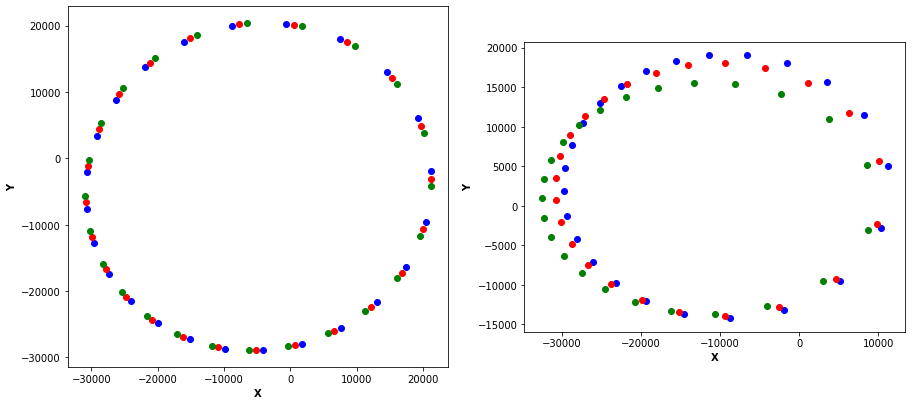

In [5]:
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd

fig, axes = plt.subplots(1, 2, figsize=(15,15))
ax1, ax2 = (axes[0], axes[1])

def graficar(df_sat, ax, col1='x', col2='y'):
    # creating a geometry column 
    geometry = [Point(xy) for xy in zip(df_sat[col1], df_sat[col2])]

    # Creating a Geographic data frame 
    gdf = gpd.GeoDataFrame(df_sat, geometry=geometry)

    ax = gdf.iloc[:24,:].geometry.plot(color='blue', marker='o', ax=ax)
    gdf.iloc[570:594,:].geometry.plot(color='red', marker='o', ax=ax)
    gdf.iloc[-24:,:].geometry.plot(color='green', marker='o', ax=ax)

    ax.set_xlabel('X', fontweight='bold')
    ax.set_ylabel('Y', fontweight='bold')

graficar(df[df.sat_id==123], ax1)
graficar(df[df.sat_id==1], ax2)
plt.savefig(f'Fig0.png')

In [6]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

def graficar(df_sat, ax):
    ax.plot_wireframe(np.array([df_sat['x'].iloc[:25]]), 
                       np.array([df_sat['y'].iloc[:25]]), 
                       np.array([df_sat['z'].iloc[:25]]), color='blue')

    ax.plot_wireframe(np.array([df_sat['x'].iloc[570:595]]), 
                      np.array([df_sat['y'].iloc[570:595]]), 
                      np.array([df_sat['z'].iloc[570:595]]), color='red')

    ax.plot_wireframe(np.array([df_sat['x'].iloc[-25:]]), 
                      np.array([df_sat['y'].iloc[-25:]]), 
                      np.array([df_sat['z'].iloc[-25:]]), color='green')

    ax.set_xlabel('X', fontweight='bold')
    ax.set_ylabel('Y' ,fontweight='bold')
    ax.set_zlabel('Z' ,fontweight='bold')

graficar(df[df.sat_id==123], ax1)
graficar(df[df.sat_id==1], ax2)

plt.savefig(f'Fig3.png')
#plt.show()

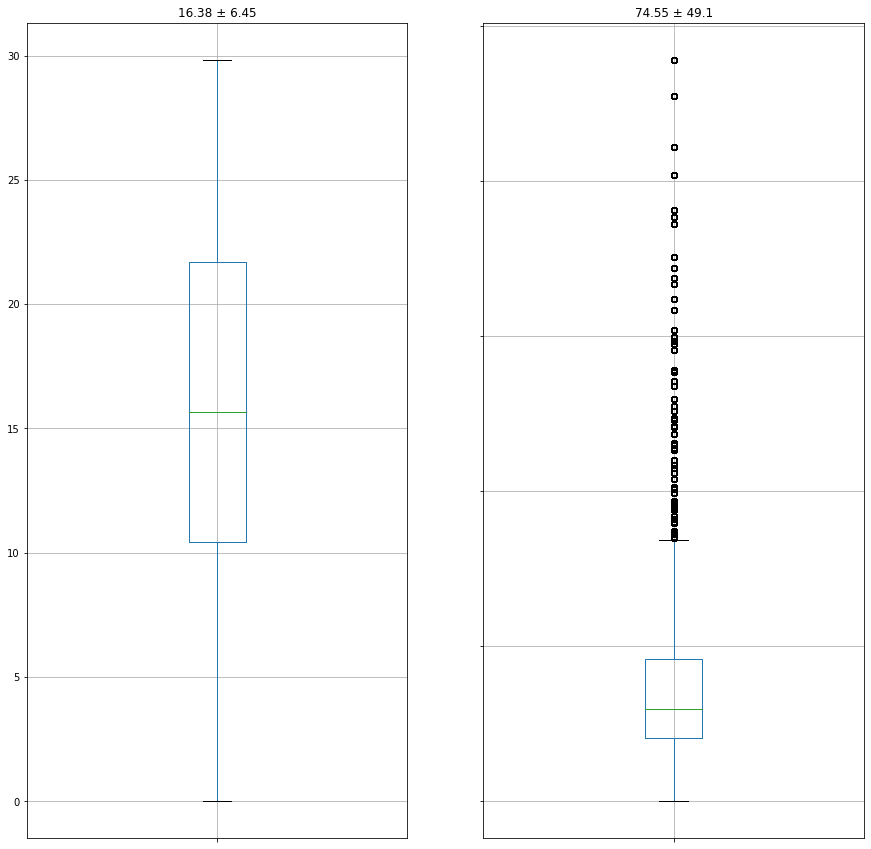

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15,15))
ax1, ax2 = (axes[0], axes[1])

pd.DataFrame((df.diff_epoch*t)).boxplot(column=['diff_epoch'], ax=ax1)
ax1.set_title(f"{round(df.diff_epoch.mean()*t,2)} \u00B1 {round(df.diff_epoch.std()*t,2)}")
ax1.set_xticklabels([])

pd.DataFrame((data[to_delete].diff_epoch*t)).boxplot(column=['diff_epoch'], figsize=(2,5), ax=ax2)
ax2.set_title(f"{round(data[to_delete].diff_epoch.mean()*t,2)} \u00B1 {round(data[to_delete].diff_epoch.std()*t,2)}")
ax2.set_xticklabels([])
ax2.label_outer()

plt.savefig(f'Fig2.png')

In [8]:
# extraigo el día y la hora de la columna epoch
df = df.assign(**{t:getattr(df.epoch.dt,t) for t in ['day','hour']})

# calculo los minutos transcurridos de cada horario con respecto al comienzo del día
df['min_aux'] = df.epoch.dt.strftime('%H:%M').str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

# acumulo los minutos transcurridos desde el las 00 del primer día de medición (1-ene)
df['minute'] = df.apply(lambda x: x.min_aux + 60 * 24 * (x.day - 1), axis=1)

# redondeo la posición del satélite en cada dimensión a dos decimales 
#df[['x','y','z']] = df[['x','y','z']].round(2)

# dascarto las columnas de posición y velocidad simuladas
df = df[['sat_id','epoch','date','day','hour','min_aux','minute','x','y','z']]

In [9]:
# ejemplo para revisar la transformación del epoch en la columna minute
df.iloc[65:72,:]

sat_id                   epoch        date  day  hour  min_aux  minute  \
806       1 2014-01-01 22:57:49.912  2014-01-01    1    22     1377    1377   
807       1 2014-01-01 23:19:01.757  2014-01-01    1    23     1399    1399   
808       1 2014-01-01 23:40:13.602  2014-01-01    1    23     1420    1420   
809       1 2014-01-02 00:01:25.447  2014-01-02    2     0        1    1441   
810       1 2014-01-02 00:22:37.292  2014-01-02    2     0       22    1462   
811       1 2014-01-02 00:43:49.136  2014-01-02    2     0       43    1483   
812       1 2014-01-02 01:05:00.981  2014-01-02    2     1       65    1505   

                x             y            z  
806 -26101.767749  -7160.063589  -383.294967  
807 -23238.540146  -9796.050489  1479.975081  
808 -19445.280606 -12033.337034  3280.907360  
809 -14636.746490 -13629.362494  4904.026390  
810  -8758.032459 -14198.163566  6152.555046  
811  -1917.423058 -13107.836690  6672.349534  
812   5169.837406  -9435.419002  5856.289979

In [10]:
df[df.sat_id==123].date.nunique()

24

In [11]:
# obtengo la cantidad de muestras por día del satélite con ids 123
df[df.sat_id==123].groupby('date').agg({'epoch':'count'}).reset_index().head(2)

date  epoch
0  2014-01-01     49
1  2014-01-02     49

In [12]:
# no todos los satélites tienen la misma cantidad de muestras
df[df.sat_id==1].groupby('date').agg({'epoch':'count'}).reset_index().head(2)

date  epoch
0  2014-01-01     68
1  2014-01-02     68

In [13]:
# genero dos rankings defasados en 1 para relacionar cada posición del satélite con su siguiente posición
df['rank_t'] = df.groupby('sat_id')['minute'].rank(ascending=True).astype(int)
df['rank_f'] = (df['rank_t'] + 1).astype(int)

# podría generarse también datos nuevos relacionando la posición del satélite con su siguiente siguiente posición
# joineo las posiciones de cada satélite con su siguiente posición en el tiempo
df = pd.merge(df[df.columns.difference(['rank_t'])], df[['sat_id','rank_t','epoch','x','y','z']], left_on=['sat_id','rank_f'], right_on=['sat_id','rank_t'], how='inner')

# renombro las columnas
df.rename(columns={'epoch_y':'next_epoch','x_y':'next_x','y_y':'next_y','z_y':'next_z','epoch_x':'epoch','x_x':'x','y_x':'y','z_x':'z'}, inplace=True)

# calculo diferencia en minutos 
df['time_diff'] = df.next_epoch.sub(df.epoch).dt.total_seconds().div(60)

# filtro las columnas importantes 
df = df[['sat_id','epoch','date','day','hour','minute','x','y','z','next_epoch','time_diff','next_x','next_y','next_z']]

df.to_csv('df_'+filename, index=False)

# muestro tres filas para ver cómo quedó la transformación
df.head(3)

sat_id                   epoch        date  day  hour  minute  \
0       1 2014-01-01 00:00:00.000  2014-01-01    1     0       0   
1       1 2014-01-01 00:21:11.845  2014-01-01    1     0      21   
2       1 2014-01-01 00:42:23.690  2014-01-01    1     0      42   

              x             y            z              next_epoch  time_diff  \
0  10390.313089  -2796.458271  3179.562085 2014-01-01 00:21:11.845  21.197417   
1  11195.606833   5078.653968  -839.076593 2014-01-01 00:42:23.690  21.197417   
2   8235.556436  11445.904263 -4680.514023 2014-01-01 01:03:35.534  21.197400   

         next_x        next_y       next_z  
0  11195.606833   5078.653968  -839.076593  
1   8235.556436  11445.904263 -4680.514023  
2   3560.149776  15634.195146 -7654.177182

In [14]:
print('df_'+filename)

df_jan_train.csv


In [15]:
# nos centramos en un satélite en particular
# probar el sat_id 123, el 1 y el 5

############################
#sat_ids = [123]
sat_ids = df.sat_id.unique()
############################

#### Obtener las mediciones del satélite alrededor de una posición target

In [16]:
def find_closest_values(target, source, k_matches=1):
    k_above = source[source >= target].nsmallest(k_matches)
    k_below = source[source < target].nlargest(k_matches)
    k_all = pd.concat([k_below, k_above]).sort_values()
    return k_all

def get_idx_and_val(target, source):
    
    k_all = find_closest_values(target, source, k_matches=1)
    #print(k_all)
    diff = (k_all - target).abs()
    #print(diff)
    idx = diff.idxmin()
    # new target
    target = k_all[idx]    
    return idx, target

def get_values(df_sat, targets):
    values = {}
    for col in ['x','y','z']:
        #print('col -->', col)
        values[col] = []
        source = df_sat[['date','minute',col]].copy()
        #target = (min(source[col])+max(source[col]))/2
        #target = source[col].median()
        target = targets[col]
        #print('target -->', target, ', len -->', len(source))
        for dt in df_sat.date.unique():
            #print(dt)
            source_dt = source[source.date==dt].reset_index()
            idx, val = get_idx_and_val(target, source_dt[col])
            i = 0
            first_idx = idx
            while idx > i:
                #print('target -->', target, ', len -->', len(source_dt), ', idx :', idx, ', val :', val)
                values[col].append([source_dt.loc[idx,'date'], source_dt.loc[idx,'minute'], source_dt.loc[idx,col]])
                i = idx
                source_dt.loc[idx,col] = np.inf
                idx, val = get_idx_and_val(target, source_dt[col])
                #print('¿target -->', target, ', len -->', len(source_dt), ', idx :', idx, ', i :', i, ', val :', val, '?') 
            i = idx
            second_idx = idx
            #print('i -->', i, ', first_idx -->', first_idx, ', second_idx -->', second_idx)
            while i < first_idx and i >= second_idx: 
                #print('-target -->', target, ', len -->', len(source_dt), ', idx :', idx, ', val :', val) 
                values[col].append([source_dt.loc[idx,'date'], source_dt.loc[idx,'minute'], source_dt.loc[idx,col]])
                source_dt.loc[idx,col] = np.inf
                second_idx = idx
                idx, val = get_idx_and_val(target, source_dt[col])
                i = idx            
                #print('¿target -->', target, 'idx :', idx, 'i -->', i, ', first_idx -->', first_idx, ', second_idx -->', second_idx, ', val :', val, '?') 

                #print(len(values[col]))
    return values

def get_df(values, col):
    #print(col)
    df_position = pd.DataFrame(values[col], columns=['date','minute',col])
    #print(len(df_position))
    #to_remove = (df_position[col]>df_position[col].mean()+1.5*df_position[col].std())|(df_position[col]<df_position[col].mean()-1.5*df_position[col].std())
    #print(sum(to_remove))
    #df_position = df_position[(df_position[col]<=df_position[col].mean()+1.5*df_position[col].std())&(df_position[col]>=df_position[col].mean()-1.5+df_position[col].std())]
    #print(len(df_position))
    return df_position

orig_stdout = sys.stdout
f = open('by_position.txt', 'w')
sys.stdout = f

for sat_id in sat_ids: 
    # me quedo con las mediciones del satélite
    df_sat = df[df.sat_id==sat_id]
    # elijo una posición target cualquiera del satélite, en este caso la 10
    targets = df_sat.iloc[10,:][['x','y','z']].to_dict()
    values = get_values(df_sat, targets)
    
    df_x = get_df(values, 'x')
    df_x_y = df_x.merge(get_df(values, 'y'), how='outer', on=['date','minute'])
    df_x_y_z = df_x_y.merge(get_df(values, 'z'), how='outer', on=['date','minute'])
    print('SAT_ID', sat_id, len(df_x_y_z))
    print(tabulate(df_x_y_z.sort_values(by='minute').head(6), headers=df_x_y_z.columns, showindex=False, tablefmt="psql"))

    #filename = f'sat_id_{sat_id}_by_x_y_z_con_NaN.csv'
    #df_x_y_z.sort_values(by='minute').to_csv(filename, index=False)
    
    # cuantos NaN (valores demasiado alejados del target) por dimensión hay
    print('# NaN')
    headers = ['x','y','z']
    print(tabulate(df_x_y_z[headers].isna().sum().to_frame(), tablefmt="psql"))
    
    headers = ['date','minute','x','y','z']
    check = df[df.sat_id==sat_id][headers]
    check = check[check.minute.isin(df_x_y_z.minute)]
    print(tabulate(check.sort_values(by='minute').head(6), headers=headers, showindex=False, tablefmt="psql"))    

    #filename = f'sat_id_{sat_id}_by_x_y_z_sin_NaN.csv'
    #check.to_csv(filename, index=False)   
    
    # me quedo con las tuplas (x,y,z) en las que ninguna variable sea NaN
    filename = f'by_position/sat_id_{sat_id}_by_position.csv'
    df_x_y_z[df_x_y_z[headers].isna().sum(axis=1)==0].sort_values(by='minute').to_csv(filename, index=False)
    data_by_position = pd.read_csv(filename, engine='python')
    print(len(data_by_position), data_by_position.minute.diff().mean(), data_by_position.minute.diff().std())
    print(tabulate(data_by_position.head(16), headers=headers, showindex=False, tablefmt="psql"))

sys.stdout = orig_stdout
f.close()

#### Graficar las señales (x,y,z) del satélite

In [17]:
from matplotlib.ticker import NullFormatter

def graficar(dt, por_idydia, ax):
    # el eje x corresponde al paso del tiempo
    x = por_idydia['minute']
    # el eje y corresponde a la posición del satélite en cada dimensión (x, y, z)
    # cambiar ax1 por plt
    ax.plot(x, por_idydia['x'], "r", marker="o", label='x')
    ax.plot(x, por_idydia['y'], "b", marker="o", label='y')
    ax.plot(x, por_idydia['z'], "g", marker="o", label='z')
    ax.grid()
    ax.set_ylim([-32000, 23000])
    ax.set_xticks([])
    #plt.yticks(range(-31000, 22000, 1000))
    #plt.ylabel('position')
    ax.set_xlabel(dt, fontweight='bold')
    #plt.xlabel('minute')

In [18]:
# nos centramos en un satélite y día en particular
sat_id = 123
por_id = df[(df.sat_id==sat_id)][['date','minute','x','y','z']]

fig = plt.figure(figsize=(15,15))

#ax1, ax2, ax3 = (fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133))
ax = (fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133))

dates = [min(df.date.unique()), df.date.unique()[round(df.date.nunique()/2)], max(df.date.unique())]

for i,dt in enumerate(dates):
    por_idydia = por_id[por_id.date==dt].drop(columns='date')
    print(f'Cantidad de mediciones ({dt}): {len(por_idydia)}')
    for col in ['x','y','z']:
        print(f"Rango de la columna '{col}' : [ {por_idydia[col].min()} , {por_idydia[col].max()} ]")
    
    graficar(dt, por_idydia, ax[i])
    
ax[1].label_outer()
ax[2].label_outer()
plt.savefig(f'Fig4.png')
#plt.show()

Cantidad de mediciones (2014-01-01): 49
Rango de la columna 'x' : [ -30667.78141003956 , 21226.1931590377 ]
Rango de la columna 'y' : [ -28948.568038936264 , 20284.52459576123 ]
Rango de la columna 'z' : [ -6617.4536369949365 , 9257.513656360032 ]
Cantidad de mediciones (2014-01-13): 48
Rango de la columna 'x' : [ -30808.05235786272 , 21221.25135486852 ]
Rango de la columna 'y' : [ -28928.65121507052 , 20253.31540991805 ]
Rango de la columna 'z' : [ -6706.368842041552 , 9191.649107858297 ]
Cantidad de mediciones (2014-01-24): 47
Rango de la columna 'x' : [ -30898.41991839008 , 21163.3445979717 ]
Rango de la columna 'y' : [ -28878.743697658432 , 20433.883371793014 ]
Rango de la columna 'z' : [ -6757.631419127352 , 9103.304249867848 ]


[21163.34459797 20433.88337179  9103.30424987]
[-30898.41991839 -28878.74369766  -6757.63141913]


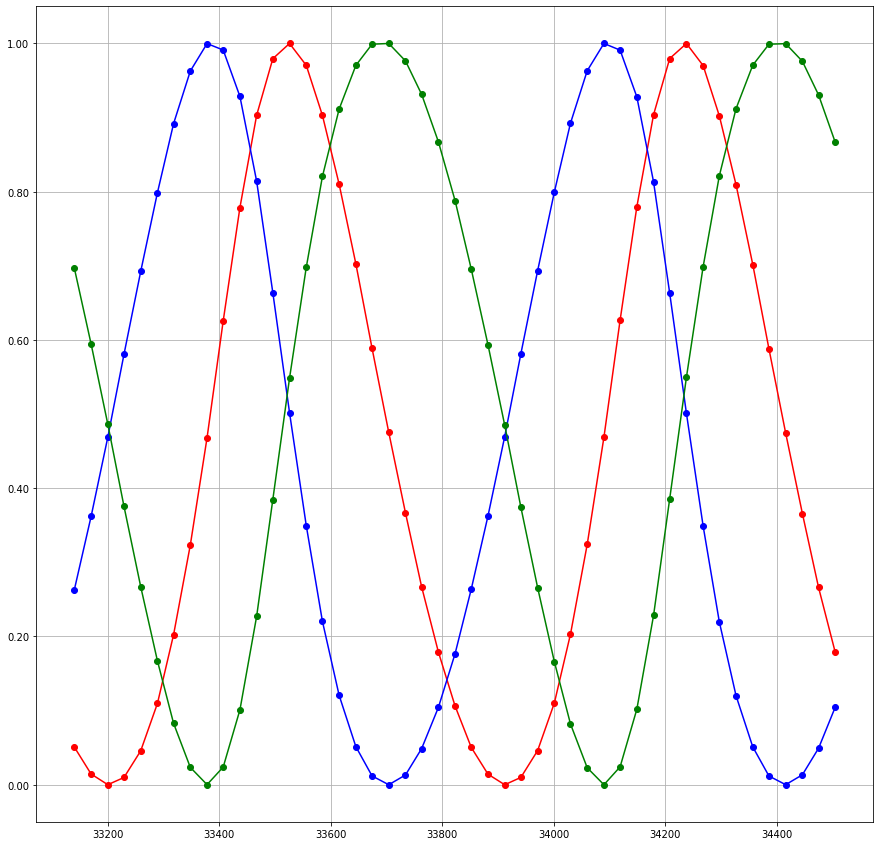

In [19]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import StrMethodFormatter

ig = plt.figure(figsize=(15,15))

data = por_idydia[['x','y','z']].to_numpy()
x = por_idydia['minute']
scaler = MinMaxScaler()
scaler.fit(data)
print(scaler.data_max_)
print(scaler.data_min_)
data = scaler.transform(data)

# el eje y corresponde a la posición del satélite en cada dimensión (x, y, z)
plt.plot(x,data[:,0], "r", marker="o", label='x')
plt.plot(x,data[:,1], "b", marker="o", label='y')
plt.plot(x,data[:,2], "g", marker="o", label='z')

plt.grid()
#plt.ylabel('position')
#plt.xlabel('minute')

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
#legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large', frameon=False)
plt.savefig(f'Fig5.png')
plt.show()

In [20]:
ax = plt.axes(projection='3d')
ax.plot3D(por_idydia['x'], por_idydia['y'], por_idydia['minute'], 'gray')
ax.scatter3D(por_idydia['x'], por_idydia['y'], por_idydia['minute'], c=por_idydia['minute'], cmap='Greens')
plt.savefig(f'sat_id_{sat_id}_x_y_minute.png')

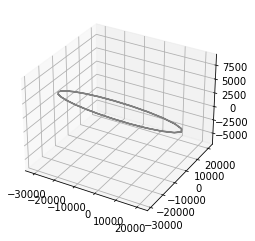

In [21]:
ax = plt.axes(projection='3d')
ax.plot3D(por_idydia['x'], por_idydia['y'], por_idydia['z'], 'gray')
plt.savefig(f'sat_id_{sat_id}_x_y_z_3d.png')

#### Comparo el ppio y final de la medición de un satélite completa

In [22]:
por_id = df[(df.sat_id==sat_id)][['minute','x','y','z']].head(100)

ig = plt.figure(figsize=(30,30))
plt.plot(por_id['minute'],por_id['x'],"r",marker="o")
plt.plot(por_id['minute'],por_id['y'],"b",marker="o")
plt.plot(por_id['minute'],por_id['z'],"g",marker="o")
plt.grid()
plt.yticks(range(-31000, 22000, 1000))
plt.show()

plt.savefig(f'sat_id_{sat_id}_x_y_z_head_100_2d.png')

<Figure size 432x288 with 0 Axes>

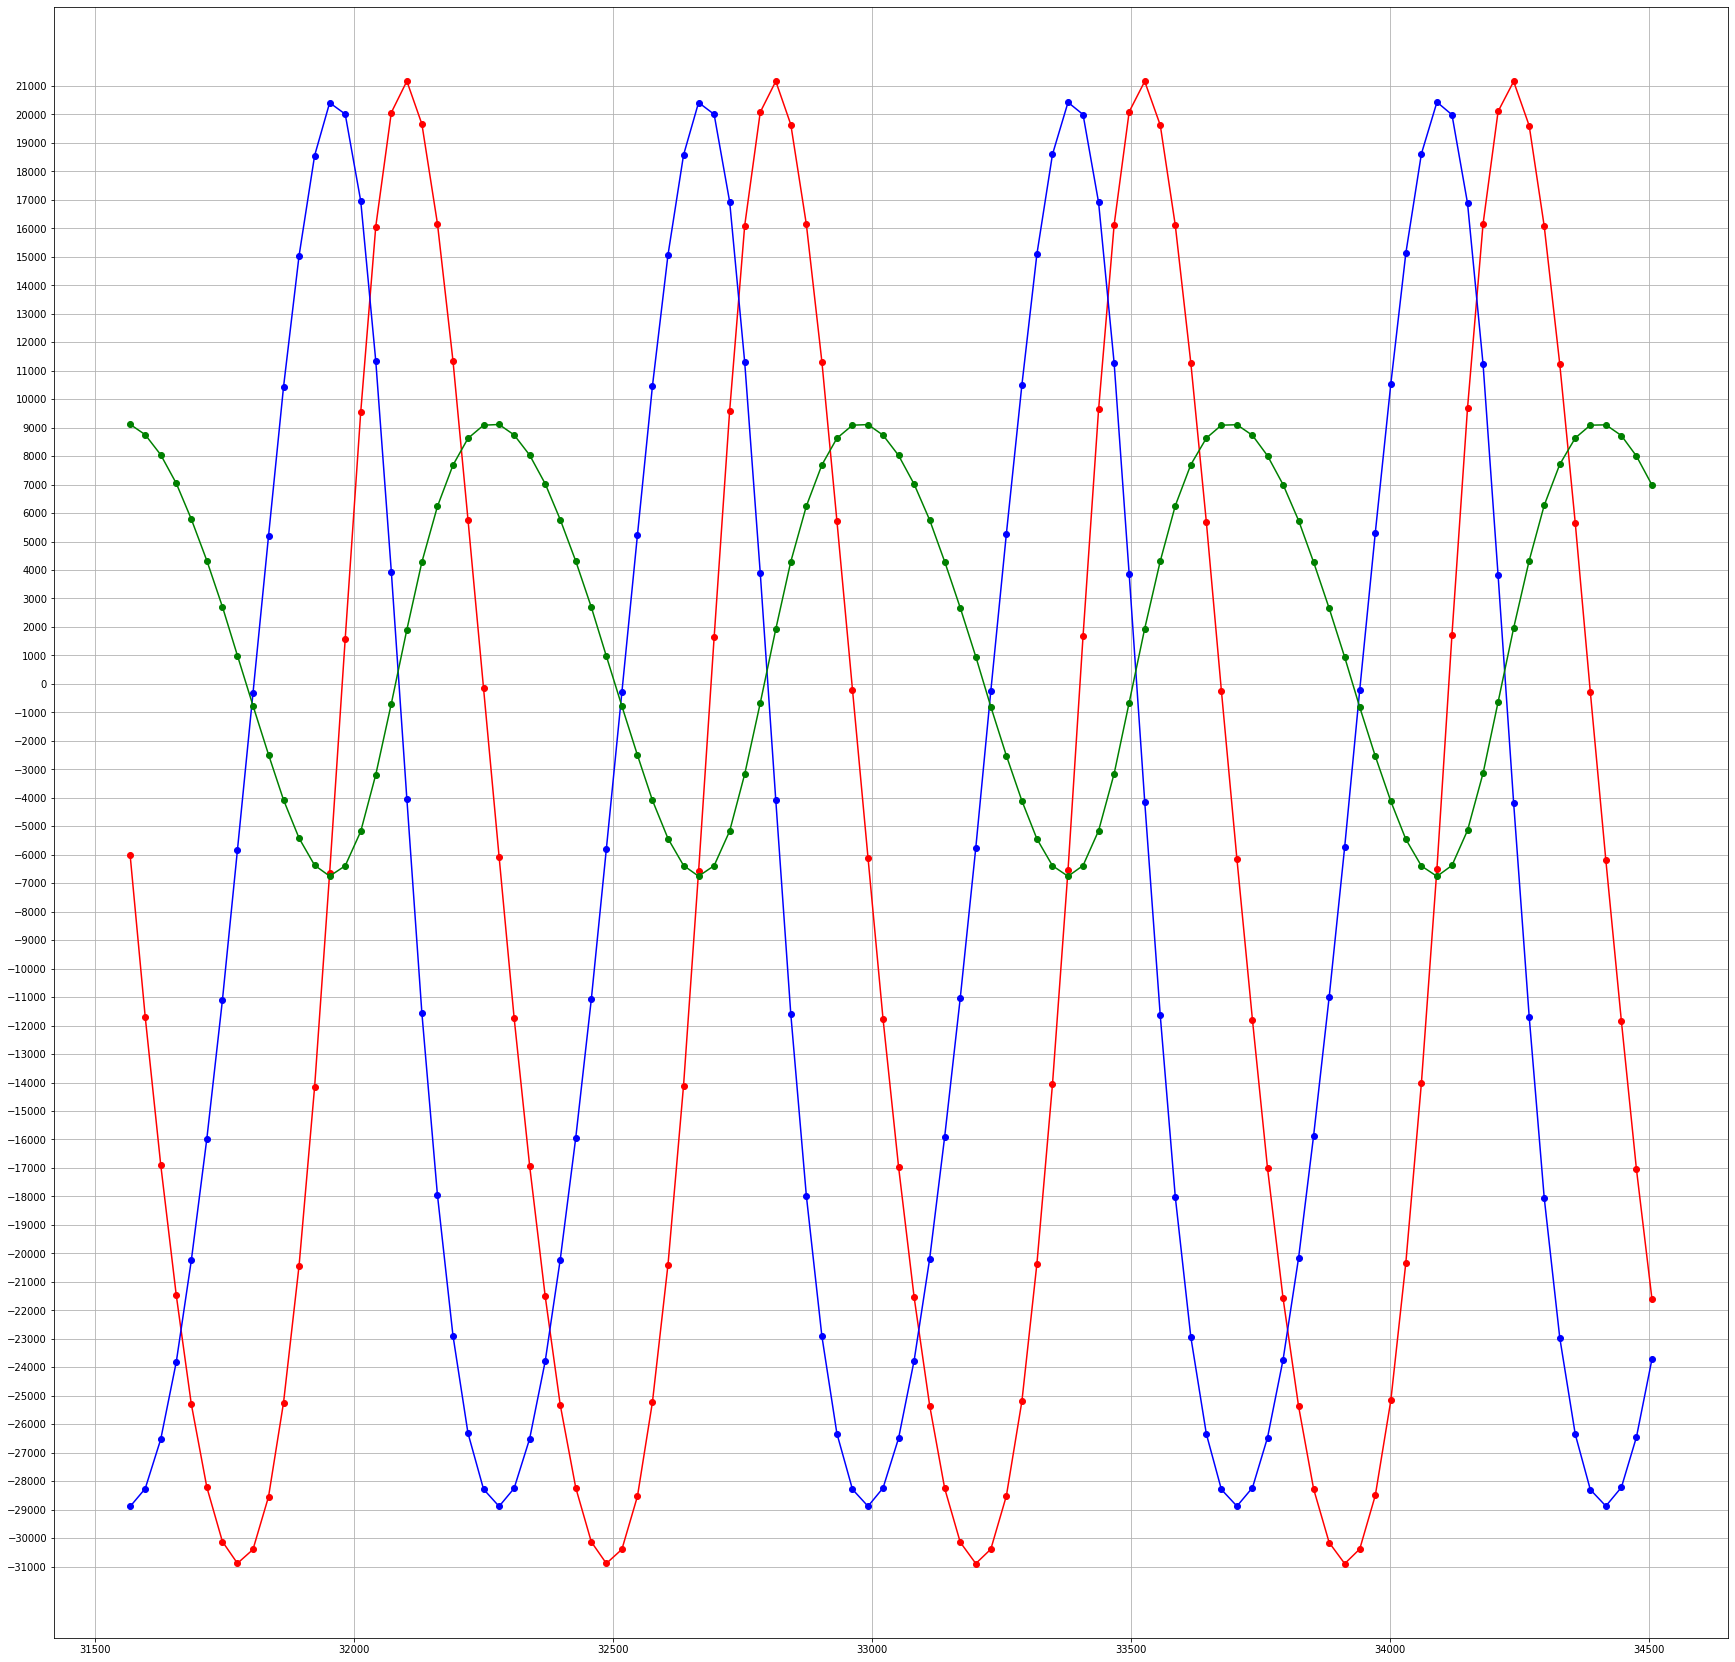

<Figure size 432x288 with 0 Axes>

In [23]:
por_id = df[(df.sat_id==sat_id)][['minute','x','y','z']].tail(100)

ig = plt.figure(figsize=(30,30))
plt.plot(por_id['minute'],por_id['x'],"r",marker="o")
plt.plot(por_id['minute'],por_id['y'],"b",marker="o")
plt.plot(por_id['minute'],por_id['z'],"g",marker="o")
plt.grid()
plt.yticks(range(-31000, 22000, 1000))
plt.show()

plt.savefig(f'sat_id_{sat_id}_x_y_z_tail_100_2d.png')

#### Obtener los picos de una de las dimensiones (en este caso la x) para determinar los ciclos del satélite

In [24]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

#orig_stdout = sys.stdout
#f = open('by_cicle.txt', 'w')
#sys.stdout = f

for sat_id in sat_ids:
    
    ##################################################################
    df_sat = df[(df.sat_id==sat_id)].reset_index(drop=True)
    #df_sat = df[(df.sat_id==sat_id)].tail(100).reset_index(drop=True)
    ##################################################################

    minute = df_sat['minute']
    x = df_sat['x']
    y = df_sat['y']
    z = df_sat['z']
    print(len(minute),len(x),len(y),len(z))
    peaks, _ = find_peaks(x, height=0)
    #plt.plot(x)
    #plt.plot(peaks, x[peaks], "x")
    #plt.plot(np.zeros_like(x), "--", color="gray")
    #plt.show()
    
    rounds = pd.Series([len(peaks)]*len(minute))
    for p, peak in reversed(list(enumerate(peaks))):
        #print(p, peak)
        rounds[:peak] = p

    min_p = min(peaks)
    max_p = max(peaks)
    print(min_p,max_p)
    x = x[min_p:max_p]
    y = y[min_p:max_p]
    z = z[min_p:max_p]
    cicles = rounds[min_p:max_p]
    minute = minute[min_p:max_p]
    print(len(minute),len(x),len(y),len(z),len(cicles))

    filename = f'by_cicle/sat_id_{sat_id}_by_cicles.csv'
    columns = ['minute', 'cicle', 'x', 'y', 'z']
    pd.DataFrame(list(zip(minute, cicles, x, y, z)), columns=columns).sort_values(by='minute').to_csv(filename, index=False)
    

    data_by_cicle = pd.read_csv(filename, engine='python').head()    
    print('SAT_ID', sat_id, len(data_by_cicle), data_by_cicle.minute.diff().mean(), data_by_cicle.minute.diff().std())
    print(tabulate(data_by_cicle.head(16), headers=columns, showindex=False, tablefmt="psql"))

#sys.stdout = orig_stdout
#f.close()

1630 1630 1630 1630
1 1608
1607 1607 1607 1607 1607
SAT_ID 1 5 21.0 0.0
+----------+---------+----------+----------+------------+
|   minute |   cicle |        x |        y |          z |
|----------+---------+----------+----------+------------|
|       21 |       1 | 11195.6  |  5078.65 |   -839.077 |
|       42 |       1 |  8235.56 | 11445.9  |  -4680.51  |
|       63 |       1 |  3560.15 | 15634.2  |  -7654.18  |
|       84 |       1 | -1580.48 | 18023.3  |  -9755.29  |
|      105 |       1 | -6627.51 | 19064    | -11129.9   |
+----------+---------+----------+----------+------------+
2732 2732 2732 2732
24 2710
2686 2686 2686 2686 2686
SAT_ID 5 5 12.75 0.5
+----------+---------+----------+-------------+----------+
|   minute |   cicle |        x |           y |        z |
|----------+---------+----------+-------------+----------|
|      303 |       1 | 13964    |     46.1684 | 1458.58  |
|      316 |       1 | 13413.4  |  -4062.71   | 1306.71  |
|      328 |       1 | 11767.3  |  -7

#### Obtener las mediciones del satélite alrededor de un horario determinado (según la duración del ciclo)

In [ ]:
from datetime import datetime, timedelta

hour_int = 4
hour_str = str(hour_int)
hour_dt = datetime.strptime(str(hour_str), '%H')

hour_day = hour_dt.day
hour_lim = hour_int

orig_stdout = sys.stdout
f = open('by_moment.txt', 'w')
sys.stdout = f

for sat_id in sat_ids:
#for sat_id in [123]:
    
    filename = f'by_cicle/sat_id_{sat_id}_by_cicles.csv'
    cicles_data = pd.read_csv(filename, engine='python').sort_values(by='minute')
    print('Cantidad de ciclos :', cicles_data.cicle.nunique())
    cicles_data = cicles_data.loc[cicles_data.groupby(['cicle']).minute.idxmin()]
    cicle_duration = cicles_data.minute.diff().mean()
    assert cicle_duration > 60, f"Satélite {sat_id} con duración menor a una hora !!!"
    print('Duración en minutos por ciclo :', round(cicle_duration,2))
    print('Duración en horas por ciclo :', round(cicle_duration/60,2))
    
    cond_1 = True
    cond_2 = True

    #######################
    #cicle_duration = 5.3*60
    
    #cicle_duration_minute = round(cicle_duration)
    #cicle_duration_hour = round(cicle_duration_minute/60)
    
    #print('-->', cicle_duration_minute, cicle_duration_hour)
    #######################

    hours = [hour_int]
    while True:

        #timedelta(hours=12, minutes=30, seconds=56)
        hour_dt = hour_dt + timedelta(minutes=cicle_duration)
        hour_int = hour_dt.hour
        
        if hour_day == hour_dt.day:
            hours.append(hour_int)
        elif hour_int < hour_lim:
            hours.append(hour_int)
        else:
            break

    print('SAT_ID', sat_id, hours) 
    
    cuales = np.array([(df_sat.hour==hour).to_list() for hour in hours]).any(axis=0)
    minute = 30
    lim = round(df_sat.minute.diff().mean()/2)

    df_hour = df_sat[cuales].copy()
    #df_hour = df_sat[(df_sat.hour==4)|(df_sat.hour==16)].copy()

    df_hour['time'] = [epoch_dt.minute for epoch_dt in df_hour['epoch']]
    df_hour = df_hour[(df_hour.time>minute-lim)&(df_hour.time<minute+lim)]
    df_hour.groupby(['day','hour']).agg({'sat_id':'count'}).reset_index()

    filename = f'by_moment/sat_id_{sat_id}_by_moment.csv'
    columns = ['date','hour','time','minute','x','y','z']
    df_hour[columns].sort_values(by='minute').to_csv(filename, index=False)
    
    print(tabulate(pd.read_csv(filename, engine='python').head(10), headers=columns, showindex=False, tablefmt="psql"))
    
sys.stdout = orig_stdout
f.close()      

In [ ]:
cuantos = len(por_idydia)
print('Cantidad de muestras:', cuantos)
diffs = {col : np.full((cuantos, cuantos), np.inf) for col in ['x','y','z']}
for col in ['x','y','z']:
    diff = diffs[col]
    for i in range(0, cuantos):
        for j in range(0, cuantos):
            prior_pos = por_idydia[col].iloc[i]
            next_pos = por_idydia[col].iloc[j]
            #diff[col][i][j] = abs(prior_pos-next_pos) if i != j else diff[i][j]
            diff[i][j] = next_pos-prior_pos if i != j else diff[i][j]
            #print(prior_pos, next_pos, diff[i][j])
diffs['x']

In [ ]:
cuantos = 20
#cuantos = len(por_idydia)
diff = np.full((cuantos, cuantos), np.inf)
for i in range(0, cuantos):
    for j in range(0, cuantos):
        prior_pos = por_idydia[col].iloc[i]
        next_pos = por_idydia[col].iloc[j]
        #diff[i][j] = abs(prior_pos-next_pos) if i != j else diff[i][j]
        diff[i][j] = next_pos-prior_pos if i != j else diff[i][j]
        #print(prior_pos, next_pos, diff[i][j])

In [ ]:
por_idydia.iloc[:cuantos].x

In [ ]:
diff

In [ ]:
diff_consec = [diff[i][i+1] for i in range(0,cuantos-1)]
diff_consec

In [ ]:
#Upward Trend

#1º primero con segundo y segundo con tercero --> 0
#2º segundo con tercero y tercero con cuarto --> 1
#Entonces, después de la tercera medición ... vuelve
[1 if (diff_consec[i] > 0 and diff_consec[i+1] < 0) or (diff_consec[i] < 0 and diff_consec[i+1] > 0) else 0 for i in range(0,len(diff_consec)-1)]

In [ ]:
first_pos = np.where(por_idydia[col] == min_pos)[0][0]
print(f'Primera posición : {first_pos, por_idydia.x.iloc[first_pos]} (minute {por_idydia.minute.iloc[first_pos]})')
first_pos_diff = list(diff[first_pos])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter


def generate_fake_data():
    """Generate data that looks like an example given."""
    xs = np.arange(0, 10, 0.05)
    ys = - 20 * 1./(1 + np.exp(-(xs - 5.)/0.3))
    m = xs > 7.
    ys[m] = -20.*np.exp(-(xs - 7.)[m] / 5.)

    # add noise
    ys += np.random.normal(0, 0.2, xs.size)
    return xs, ys


def main():
    #xs, ys = generate_fake_data()
    ys = por_idydia[col].iloc[:100]
    xs = por_idydia['minute'].iloc[:100]

    # smooth out noise
    smoothed = gaussian_filter(ys, 1.)
    #print(smoothed)
    
    # find the point where the signal goes above the background noise
    # level (assumed to be zero here).
    base = 0.
    std = (ys[xs < 3] - base).std()
    m = smoothed < (base - 3. * std)
    x0 = xs[m]#[0]
    y0 = ys[m]#[0]
    
    print(smoothed)

    plt.plot(xs, ys, '.')
    plt.plot(xs, smoothed, '-')
    plt.plot(x0, y0, 'o')
    plt.show()


main()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def f (x):
    return x ** 3-3 * x + 1
xs = np.linspace (-3, 3, 30)
ys = f (xs)
ys = por_idydia[col].iloc[:100].to_numpy()
xs = por_idydia['minute'].iloc[:100].to_numpy()
f_prime = np.gradient (ys) # differential approximation

indices = np.where (np.diff (np.sign (f_prime))) [0] # Find the inflection point.
infections = xs [indices]

In [ ]:
print ('inflection point', infections) # inflection point [-1.13793103 0.93103448]
fig, ax = plt.subplots (figsize = (7, 7))
ax.plot (xs, ys, 'bo-', ms = 2)
ax.plot (infections, f (infections), 'ro', ms = 5)
plt.show ()

#### Comienzo de un check

In [ ]:
por_idydia.x.iloc[1143:1148]

In [ ]:
first_pos_diff[1143:1148]

In [ ]:
por_idydia.x.iloc[1146]-por_idydia.x.iloc[1145] == first_pos_diff[1143:1148][3]

#### Fin del check

In [ ]:
ordered = sorted(first_pos_diff, reverse=True)

max_diff = ordered[1]
idx_max_diff = np.where(first_pos_diff == max_diff)[0][0]
pos_max_diff = por_idydia.x.iloc[idx_max_diff]

print(f'Posición más alejada de la inicial : {pos_max_diff} ({idx_max_diff}, {max_diff})')

In [ ]:
min_diff = ordered[-1]
idx_min_diff = np.where(first_pos_diff == min_diff)[0][0]
pos_min_diff = por_idydia.x.iloc[idx_min_diff]

print(f'Posición más cercada a la inicial : {pos_min_diff} ({idx_min_diff}, {min_diff})')

In [ ]:
# Modulos con los que trabajaremos
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

# Creamos la figura
fig = plt.figure()

# Agrrgamos un plano 3D
ax1 = fig.add_subplot(111,projection='3d')

# Datos en array bi-dimensional
x = np.array([por_idydia['x']])
y = np.array([por_idydia['y']])
z = np.array([por_idydia['z']])

# plot_wireframe nos permite agregar los datos x, y, z. Por ello 3D
# Es necesario que los datos esten contenidos en un array bi-dimensional
ax1.plot_wireframe(x, y, z)

# Mostramos el gráfico
plt.show()

In [ ]:
#con contorno:
# Creamos la figura
fig = plt.figure()

# Agrrgamos un plano 3D
ax1 = fig.add_subplot(111,projection='3d')

# Datos en array bi-dimensional
x = np.array([por_idydia['x']])
y = np.array([por_idydia['y']])
z = np.array([por_idydia['z']])

# plot_wireframe nos permite agregar los datos x, y, z. Por ello 3D
# Es necesario que los datos esten contenidos en un array bi-dimensional
xmesh,ymesh= np.meshgrid(x,y)
zmesh=np.sin((xmesh**2+ymesh**2)*0.5)
plt.contour(xmesh,ymesh,zmesh)
#ax1.plot_wireframe(x, y, z)

# Mostramos el gráfico
plt.show()

## Dispersión del eje x

In [ ]:
por_idyhora = df[ df['sat_id'] == 123 ][ df['time'] == 0 ]
por_idyhora

In [ ]:
import numpy as np
import matplotlib.pyplot as plt  

x = np.array(por_idyhora['x'])
y = np.array(por_idydia['y'])
print(x)
#y = np.array(por_idyhora['day'])
print(y)
#plt.plot(x,y, 'ks')
#plt.axis ([0,24,-35000,35000])
plt.scatter(x,y)
plt.show()

## Y AHORA VAMOS A CALCULAR LAS MÉTRICAS DE LA ÓRBITA EN BASE A LA ELIPSE GENERADA

###  

1.- Encontrar el plano que contiene a la elipse (en sistema de referencia original x, y, z).

2.- Proyectar en perpendicular al plano los puntos … Y guardar la información de distancia de cada punto al plano (será la métrica de la bondad del ajuste).

3.- Que ese plano pase a ser el z’=0, con lo que nos quedamos dos coordenadas (x’ e y’). Escribir la rutina de transformación matricialmente (para luego programar el resto de satélites)

4.- Buscar el centro de la elipse O’’ ajustando los puntos a una circunferencia por mínimos cuadrados. Esto no debe introducir error, porque realmente no afectará a la trayectoria (lo del punto 1 y 2 sí …).

5.- Ajustar a una recta en ese plano la nube de puntos, obligando a que pase por el centro O’’. Esa recta nos dará el eje x’’. El valor de R no es importante, porque deberá salir muy bajo.

6.- La perpendicular a esa recta y que pase por O’’ define el nuevo eje y’’.

Con ello el sistema de referencia nuevo es x’’, y’’, z’.

7.- Transformar las coordenadas a este nuevo sistema de referencia.

8.- Ajustar los puntos a una elipse. Deberá dar el eje principal en el eje x’’ y el secundario en el y’’. Lo que se desvié (que podría ser), es una medida de la bondad del ajuste.

9.- tomar nota de los siguientes parámetros:

                9.1.- Aspecto gráfico del ajuste

                9.2.- Valor R2 del ajuste.

                9.3.- Bondad en el cálculo de los parámetros de cada eje a y b.

                9.4.- Dibujar la elipse inscrita máxima que cabe dentro de los puntos y la mínima circunscrita que contiene a los puntos. Dar la distancia en cada eje … Esto es una idea que tengo … pero sirve para evaluar la bondad del ajuste … no dicho en ningún sitio … ¡¡con lo que es nuestra aportación!! …

10.- Reconvertir la ecuación en x’’, y’’, z’ a las iniciales x,y,z para hacer comparables los resultados.

In [ ]:


import statsmodels.api as sm

In [ ]:
# Modulos con los que trabajaremos
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
def figura(x,y,z):
    # Creamos la figura
    fig = plt.figure()

    # Agrrgamos un plano 3D
    ax1 = fig.add_subplot(111,projection='3d')

    # Datos en array bi-dimensional
    x = np.array([x])
    y = np.array([y])
    z = np.array([z])

    # plot_wireframe nos permite agregar los datos x, y, z. Por ello 3D
    # Es necesario que los datos esten contenidos en un array bi-dimensional
    ax1.plot_wireframe(x, y, z)

    # Mostramos el gráfico
    plt.show()
    return

In [ ]:
for i in range(50):
    por_id = df[ df['sat_id'] == i+1 ]
    figura(por_id['x'],por_id['y'],por_id['z'])
    


In [ ]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt

graphWidth = 800 # units are pixels
graphHeight = 600 # units are pixels

# 3D contour plot lines
numberOfContourLines = 16


xData = por_idydia['x'].to_numpy()#numpy.array([0.125735  , 0.11753342, 0.11572967, 0.11963533, 0.1255283 , 0.13183589, 0.13904629, 0.14754317, 0.15548172, 0.16429631, 0.17474308, 0.18641375], dtype=float)
yData = por_idydia['y'].to_numpy()#numpy.array([0.11917991, 0.10663986, 0.09897077, 0.09291739, 0.08743263, 0.08346636, 0.08161819, 0.08132199, 0.08216186, 0.0834759 , 0.08551088, 0.08770163], dtype=float)
zData = por_idydia['z'].to_numpy()#numpy.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 , 11, 12], dtype=float)

print(len(xData))
print(len(yData))
print(len(zData))




def func(data, a, b, c, d):
    x = data[0]
    y = data[1]
    return a * numpy.power(x, b) + c * numpy.power(y, d)


def SurfacePlot(func, data, fittedParameters):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)

    matplotlib.pyplot.grid(True)
    axes = Axes3D(f)

    x_data = data[0]
    y_data = data[1]
    z_data = data[2]

    xModel = numpy.linspace(min(x_data), max(x_data), 20)
    yModel = numpy.linspace(min(y_data), max(y_data), 20)
    X, Y = numpy.meshgrid(xModel, yModel)

    Z = func(numpy.array([X, Y]), *fittedParameters)

    axes.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=1, antialiased=True)

    axes.scatter(x_data, y_data, z_data) # show data along with plotted surface

    axes.set_title('Surface Plot (click-drag with mouse)') # add a title for surface plot
    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label
    axes.set_zlabel('Z Data') # Z axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot or else there can be memory and process problems


def ContourPlot(func, data, fittedParameters):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    x_data = data[0]
    y_data = data[1]
    z_data = data[2]

    xModel = numpy.linspace(min(x_data), max(x_data), 20)
    yModel = numpy.linspace(min(y_data), max(y_data), 20)
    X, Y = numpy.meshgrid(xModel, yModel)

    Z = func(numpy.array([X, Y]), *fittedParameters)

    axes.plot(x_data, y_data, 'o')

    axes.set_title('Contour Plot') # add a title for contour plot
    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    CS = matplotlib.pyplot.contour(X, Y, Z, numberOfContourLines, colors='k')
    matplotlib.pyplot.clabel(CS, inline=1, fontsize=10) # labels for contours

    plt.show()
    plt.close('all') # clean up after using pyplot or else there can be memory and process problems


def ScatterPlot(data):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)

    matplotlib.pyplot.grid(True)
    axes = Axes3D(f)
    x_data = data[0]
    y_data = data[1]
    z_data = data[2]

    axes.scatter(x_data, y_data, z_data)

    axes.set_title('Scatter Plot (click-drag with mouse)')
    axes.set_xlabel('X Data')
    axes.set_ylabel('Y Data')
    axes.set_zlabel('Z Data')

    plt.show()
    plt.close('all') # clean up after using pyplot or else there can be memory and process problems


if __name__ == "__main__":

    data = [xData, yData, zData]

    initialParameters = [100.0, 1.0, 1000.0, 1.0]

    # here a non-linear surface fit is made with scipy's curve_fit()
    fittedParameters, pcov = scipy.optimize.curve_fit(func, [xData, yData], zData, p0 = initialParameters)

    ScatterPlot(data)
    SurfacePlot(func, data, fittedParameters)
    ContourPlot(func, data, fittedParameters)

    print('fitted prameters', fittedParameters)

    modelPredictions = func(data, *fittedParameters) 

    absError = modelPredictions - zData

    SE = numpy.square(absError) # squared errors
    MSE = numpy.mean(SE) # mean squared errors
    RMSE = numpy.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (numpy.var(absError) / numpy.var(zData))
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)


In [ ]:
import scipy.optimize as op
import numpy as np
import matplotlib.pyplot as plt

f  = lambda x: np.sin(x) - 0.1*x - 0.1
df = lambda x: np.cos(x) - 0.1

x = np.linspace(-1,20,1000)

plt.figure(figsize=(15,4))
plt.plot(x,f(x))
plt.plot(x,0*x,'k-')
plt.show()

x0 = np.array([0., 2., 7., 8.])
raiz = op.newton(f,x0,fprime=df,tol=1.e-6,maxiter=100)       
print(raiz)

x0 = np.array([0., 2., 7., 8.])
raiz = op.newton(f,x0,tol=1.e-6,maxiter=100)       
print(raiz)

x0 = np.array([0., 2., 7., 8.])
x1 = x0 + 1
raiz = np.zeros_like(x0)
for i in range(len(raiz)):
    raiz[i]= op.bisect(f,x0[i],x1[i],xtol=1.e-6,maxiter=100)       
    print(raiz[i])

x = np.linspace(-1,9)

plt.figure()
plt.plot(x,f(x),x,x*0,'k',raiz,raiz*0,'ro')
plt.show()